# Anomaly detection in Taxi demand with LSTM
In this notebook we try to predict Taxi demand in New York City in a critical time period. We explore the dataset to formulate important assumptions about taxi demand and human behaviour driving it, e.g. demand surges on certain days.

All the heavy lifting is made by LSTM developed in Keras, which forecasts demand and detect anomalies at the same time.

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style('whitegrid')

import tqdm
import datetime

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_log_error, mean_squared_error

from keras.models import *
from keras.layers import *
from keras.layers.core import Lambda
from keras import backend as K

### Dataset
NYC Taxi Datase shows the NYC taxi demand from 2014–07–01 to 2015–01–31 with an observation every half hour.

In [2]:
# read the data
df = pd.read_csv('nyc_taxi.csv')
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10320 entries, 0 to 10319
Data columns (total 2 columns):
timestamp    10320 non-null object
value        10320 non-null int64
dtypes: int64(1), object(1)
memory usage: 161.4+ KB
None


,timestamp,value
0,2014-07-01 00:00:00,10844
1,2014-07-01 00:30:00,8127
2,2014-07-01 01:00:00,6210
3,2014-07-01 01:30:00,4656
4,2014-07-01 02:00:00,3820


In [3]:
# create features year, month, day, hour
df['timestamp'] = pd.to_datetime(df['timestamp'], format = '%Y-%m-%d %H:%M:%S')
df['year'] = df['timestamp'].dt.year
df['month'] = df['timestamp'].dt.month
df['day'] = df['timestamp'].dt.day
df['hour'] = df['timestamp'].dt.hour

In [4]:
df.head()

,timestamp,value,year,month,day,hour
0,2014-07-01 00:00:00,10844,2014,7,1,0
1,2014-07-01 00:30:00,8127,2014,7,1,0
2,2014-07-01 01:00:00,6210,2014,7,1,1
3,2014-07-01 01:30:00,4656,2014,7,1,1
4,2014-07-01 02:00:00,3820,2014,7,1,2


(array([735415., 735446., 735477., 735507., 735538., 735568., 735599.,
        735630.]), <a list of 8 Text xticklabel objects>)

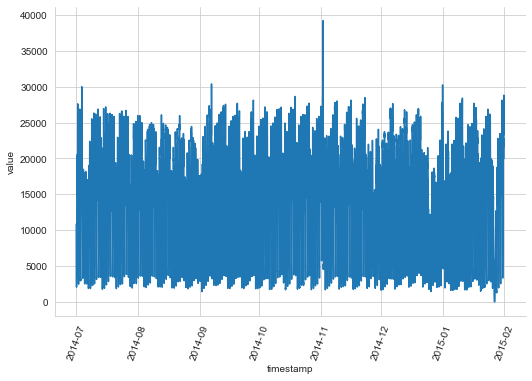

In [27]:
# plot one week sample of the data
sns.relplot(x='timestamp', y='value', kind='line', aspect=1.5, data=df)
plt.xticks(rotation=70)

In this period 5 anomalies are present, in term of deviation from a normal behavior. They occur respectively during the NYC marathon, Thanksgiving, Christmas, New Years day, and a snow storm.

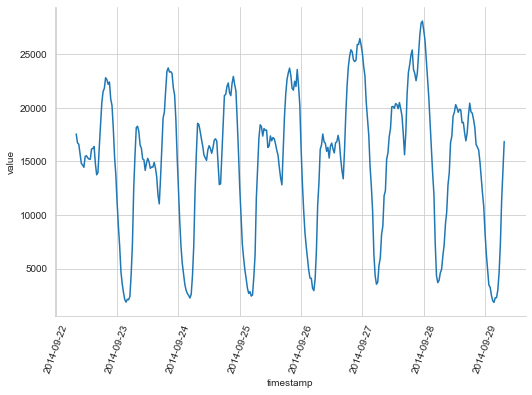

In [6]:
# plot one week sample of the data in the nyc marathon week
sns.relplot(x='timestamp', y='value', kind='line', aspect=1.5, data=df.iloc[4000:4000+7*48,:])
plt.xticks(rotation=70);

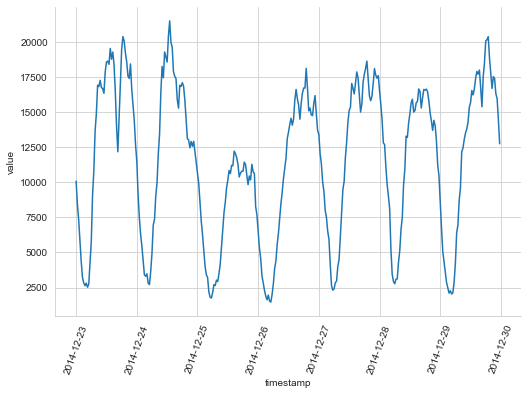

In [7]:
# check demand on Chrismas and New Year day
sns.relplot(x='timestamp', y='value', kind='line', aspect=1.5, data=df.iloc[8400:8400+7*48,:])
plt.xticks(rotation=70);

## Behavioral patterns
* The first consideration we noticed, looking at the data, is the presence of an obvious __daily pattern__ (during the day the demand is higher than during the night hours). 
* The taxi demand seems to be driven also by a __weekly trend__: in certain days of the week the taxi demand is higher than others. We can explore this by computing autocorrelation.

In [8]:
# weekly autocorrelaton plot (10 weeks depth)
timeLags = np.arange(1, 10*48*7)
autoCorr = [df['value'].autocorr(lag=dt) for dt in timeLags]

Text(0, 0.5, 'correlation coef')

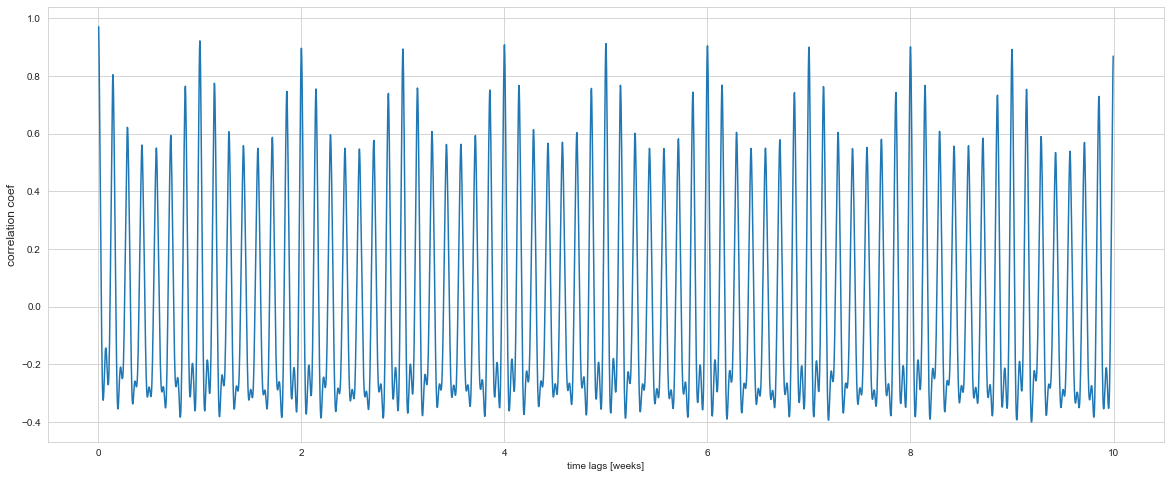

In [9]:
plt.figure(figsize=(20,8))
plt.plot(1.0/(48*7)*timeLags, autoCorr)
plt.xlabel('time lags [weeks]')
plt.ylabel('correlation coef', fontsize=12)

Autocorrelation plot proves the weekly trend, so we'll note this important behaviour for further analysis.

## Feature creation
Next, we compute and store the means for every day of the week at the hour level. This will be useful when we’ll standardize the data to build our model in order to reduce every kind of temporal dependency.

I compute the means for the first 5000 observations that will become our future train set

In [10]:
df['weekday'] = df['timestamp'].dt.weekday

In [11]:
df = df.join(df[:5000].groupby(['weekday', 'hour'])['value'].mean(), on=['weekday', 'hour'], rsuffix='_r')
df = df.rename(columns={'value_r': 'weekday_mean'})

In [12]:
df.head()

,timestamp,value,year,month,day,hour,weekday,weekday_mean
0,2014-07-01 00:00:00,10844,2014,7,1,0,1,8774.433333
1,2014-07-01 00:30:00,8127,2014,7,1,0,1,8774.433333
2,2014-07-01 01:00:00,6210,2014,7,1,1,1,5242.933333
3,2014-07-01 01:30:00,4656,2014,7,1,1,1,5242.933333
4,2014-07-01 02:00:00,3820,2014,7,1,2,1,3170.433333


## Model Definition
We need a strategy to detect outliers in advance. To do this, we choose to care about taxi demand predictions. We want to develop a model which is able to forecast demand taking into account uncertainty. One way to do this is to develop __quantile regression__. We focus on predictions of extreme values: 
* lower (10th quantile), 
* upper (90th quantile) 
* and classical 50th quantile. 

Computing also the 90th and 10th quantile we cover the most likely values that occur in daily life. The width of this range can vary a lot: 
* we know that it is small when our model is sure about the future 
* it can be huge when our model isn’t able to forecast important changes in the domain of interest. 

We take advantage of this behaviour and let our model say something about outlier detection in the field of taxi demand preditcion. We are expecting to get a tiny interval (90–10 quantile range) when our model is sure about the future because it has everything under control; on the other hand we are expecting to get an anomaly when the interval becomes larger. Interval will grow larger because our model isn’t trained to handle this kind of scenario which can results in anomaly.

We make all this magic a reality by building a simple LSTM Neural Network in Keras. Our model will receive as input the past observations. We resize our data for feeding our LSTM with daily window size (48 observations: one observation for every half hour). When we were generating data, we do logarithmic transformation and standardization subtracting the mean daily hour values, in order to see an observation as the logarithmic variation from its daily mean hour value. 

In [13]:
# Create Generator for LSTM sequences
sequence_length = 48  # one day represented with 48 values, 1 every half hour

def gen_index(id_df, seq_length, seq_cols):

    data_matrix =  id_df[seq_cols]
    num_elements = data_matrix.shape[0]

    for start, stop in zip(range(0, num_elements-seq_length, 1), range(seq_length, num_elements, 1)):       
        yield data_matrix[stop-sequence_length:stop].values.reshape((-1,len(seq_cols)))

In [14]:
# Create and standardise DATA for LSTM
cnt, mean = [], []
for sequence in gen_index(df, sequence_length, ['value']):
    cnt.append(sequence)
    
for sequence in gen_index(df, sequence_length, ['weekday_mean']):
    mean.append(sequence)

cnt, mean = np.log(cnt), np.log(mean)
cnt = cnt - mean
cnt.shape

(10272, 48, 1)

We build our target variables in the same way with half hour shifting (we want to predict the demand values for the next thirty minutes).

In [15]:
# Create and standardise LABEL for LSTM
init = df.weekday_mean[sequence_length:].apply(np.log).values
label = df.value[sequence_length:].apply(np.log).values - init
label.shape

(10272,)

For doing quantile regression in Keras I took inspiration from [this post](https://towardsdatascience.com/deep-quantile-regression-c85481548b5a). We need to define the custom quantile loss function which penalizes errors based on the quantile and whether the error was positive (actual > predicted) or negative (actual < predicted). Our network has 3 outputs and 3 losses, one for every quantile we try to predict.

Keras loss functions must only take (y_true, y_pred) as parameters. So we need a separate function for keras model taking q_loss. We define it below with anonymus lambda function.
* y = y_true
* f = y_pred

See also [this post](https://stackoverflow.com/questions/45961428/make-a-custom-loss-function-in-keras)for defining custom loss function.

In [16]:
### Define Quantile Loss
def q_loss(q,y,f):
    e = (y-f)
    return K.mean(K.maximum(q*e, (q-1)*e), axis=-1)

In [17]:
### Split dataset into train and test sets
X_train, X_test = cnt[:5000], cnt[5000:]
y_train, y_test = label[:5000], label[5000:]

In [18]:
# Model Definition
losses = [lambda y,f: q_loss(0.1,y,f), 
          lambda y,f: q_loss(0.5,y,f), 
          lambda y,f: q_loss(0.9,y,f)]

inputs = Input(shape=(X_train.shape[1], X_train.shape[2]))
lstm = Bidirectional(LSTM(64, return_sequences=True, dropout=0.3))(inputs, training = True)
lstm = Bidirectional(LSTM(16, return_sequences=False, dropout=0.3))(lstm, training = True)
dense = Dense(50)(lstm)
out10 = Dense(1)(dense)
out50 = Dense(1)(dense)
out90 = Dense(1)(dense)

model = Model(inputs, [out10,out50,out90])

model.compile(loss=losses, optimizer='adam', loss_weights = [0.3,0.3,0.3])

In [19]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 48, 1)        0                                            
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 48, 128)      33792       input_1[0][0]                    
__________________________________________________________________________________________________
bidirectional_2 (Bidirectional) (None, 32)           18560       bidirectional_1[0][0]            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 50)           1650        bidirectional_2[0][0]            
__________________________________________________________________________________________________
dense_2 (D

### Training

In [20]:
history = model.fit(X_train, [y_train,y_train,y_train], epochs=50, batch_size=128, verbose=2, shuffle=True)

Epoch 1/50
 - 9s - loss: 0.0298 - dense_2_loss: 0.0297 - dense_3_loss: 0.0448 - dense_4_loss: 0.0249
Epoch 2/50
 - 6s - loss: 0.0267 - dense_2_loss: 0.0243 - dense_3_loss: 0.0426 - dense_4_loss: 0.0220
Epoch 3/50
 - 5s - loss: 0.0262 - dense_2_loss: 0.0236 - dense_3_loss: 0.0421 - dense_4_loss: 0.0217
Epoch 4/50
 - 6s - loss: 0.0255 - dense_2_loss: 0.0227 - dense_3_loss: 0.0411 - dense_4_loss: 0.0213
Epoch 5/50
 - 6s - loss: 0.0249 - dense_2_loss: 0.0221 - dense_3_loss: 0.0401 - dense_4_loss: 0.0209
Epoch 6/50
 - 6s - loss: 0.0243 - dense_2_loss: 0.0212 - dense_3_loss: 0.0393 - dense_4_loss: 0.0204
Epoch 7/50
 - 6s - loss: 0.0237 - dense_2_loss: 0.0206 - dense_3_loss: 0.0383 - dense_4_loss: 0.0199
Epoch 8/50
 - 6s - loss: 0.0230 - dense_2_loss: 0.0205 - dense_3_loss: 0.0371 - dense_4_loss: 0.0192
Epoch 9/50
 - 5s - loss: 0.0223 - dense_2_loss: 0.0196 - dense_3_loss: 0.0362 - dense_4_loss: 0.0186
Epoch 10/50
 - 6s - loss: 0.0218 - dense_2_loss: 0.0194 - dense_3_loss: 0.0352 - dense_4_lo

## Quantile Bootstraping
When dealing with Neural Network in Keras, one of the tedious problems is the uncertainty of the results due to the internal weigths initialization. With its formulation, our problem seems to particularly suffer of this kind of problem, i.e. when computing quantile predictions we can’t permit quantiles to overlap, this not make sense! 

To avoid this pitfall I make use of __bootstrapping in prediction phase__: 
* reactivate dropout of my network,
* iterate predition for 100 times, store them 
* and finally calculate the desired quantiles 

(I make use of this clever technique also in [this post](https://towardsdatascience.com/extreme-event-forecasting-with-lstm-autoencoders-297492485037)).

In [21]:
# Quantile Bootstrapping
pred_10, pred_50, pred_90 = [], [], []
NN = K.function([model.layers[0].input, K.learning_phase()], # reactivates dropout for prediction
                [model.layers[-3].output,model.layers[-2].output,model.layers[-1].output])

for i in tqdm.tqdm(range(0,100)):
    predd = NN([X_test, 0.5])
    pred_10.append(predd[0])
    pred_50.append(predd[1])
    pred_90.append(predd[2])

pred_10 = np.asarray(pred_10)[:,:,0] 
pred_50 = np.asarray(pred_50)[:,:,0]
pred_90 = np.asarray(pred_90)[:,:,0]

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [03:42<00:00,  2.28s/it]


This process is graphically explained below with a little focus on a subset of predictions. Given quantile bootstraps, we calculated summary measures (red lines) of them, avoiding crossover.

<img src="images/quantile_bootstrap.png">

## Results
We used the firstly 5000 observations for training and the remaining (around 5000) for testing.

Our model reaches a great performance for forecasting taxi demand with the 50th quantile. Around 0.055 Mean Squared Log Error is a excellent result! This means that the LSTM Network is able to understand the underling rules that drive taxi demand. So our approach makes sense. 

In [22]:
# Reverse transform predictions
pred_90_m = np.exp(np.quantile(pred_90,0.9,axis=0) + init[5000:])
pred_50_m = np.exp(pred_50.mean(axis=0) + init[5000:])
pred_10_m = np.exp(np.quantile(pred_10,0.1,axis=0) + init[5000:])

In [23]:
# Evaluate the results with Log loss
mean_squared_log_error(np.exp(y_test + init[5000:]), pred_50_m)

0.05626317750388998

We've computed the difference among the 90th quantile predictions and 10th quantile predictions to check for crossover. There isn't any which is what we want! 

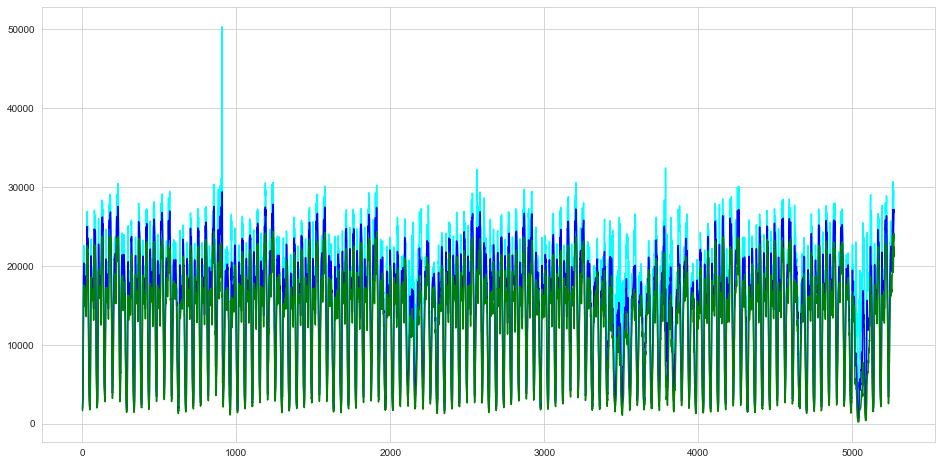

In [24]:
# Plot Quantile predictions
plt.figure(figsize=(16,8))
plt.plot(pred_90_m, color='cyan')
plt.plot(pred_50_m, color='blue')
plt.plot(pred_10_m, color='green')

# Check for quantile crossover
plt.scatter(np.where(np.logical_or(pred_50_m>pred_90_m, pred_50_m<pred_10_m))[0], 
            pred_50_m[np.logical_or(pred_50_m>pred_90_m, pred_50_m<pred_10_m)], c='red', s=50)

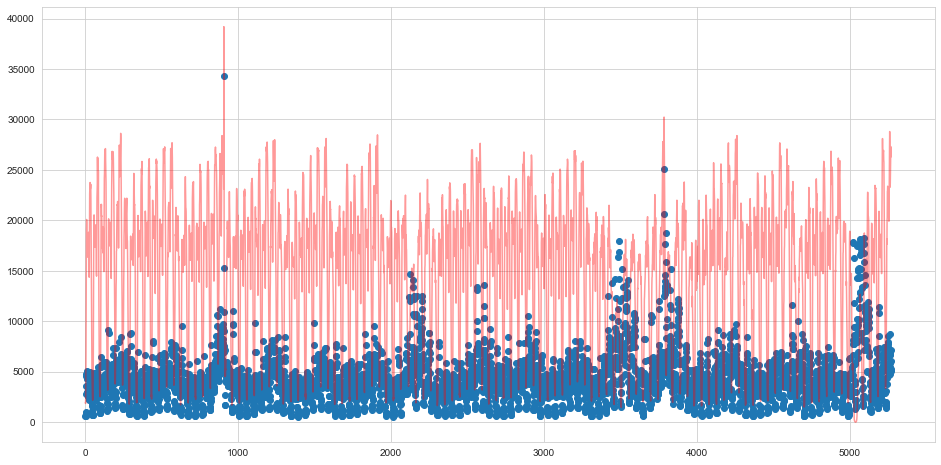

In [25]:
# Plot 90th-10th quantile uncertainity interval size over actual data
plt.figure(figsize=(16,8))
plt.plot(np.exp(y_test + init[5000:]), color='red', alpha=0.4)
plt.scatter(x=range(len(pred_10_m)), y=pred_90_m - pred_10_m)

The quantile interval range (blue dots) is higher in period of uncertainty. In the other cases, the model tends to generalize well, as we expected. Going deeper, we start to investigate about these periods of high uncertainty. We noticed that these coincide with our initial assumptions. The orange circles plotted below are respectively: NYC marathon, Thanksgiving, Christmas, New Years day, and a snow storm.

We can conclude that we reach our initial targets: achive a great forecating power and exploit the strength of our model to identificate uncertainty. We also make use of this to say something about anomalies detection.